***In21-S4-CS3111 - Introduction to Machine Learning*** <br>
**K.S. RANASINGHE**<br>
**210518H**

# Lab 02 - Regression

## Background
The dataset originates from an ML Hackathon organized by HackerEarth. It contains information on various properties located in the United States and aims to facilitate the prediction of their Habitability Score. It contains the training dataset (train.csv) which will be used to build the ML model and the testing dataset (test.csv) which will be used to see how well your model performs on unseen data.


When I was working on this problem I tried multiple techniques in different areas of the problem to improve the performance of the model. You could see that based on the 30+ submissions made on the Kaggle competition. In this notebook we will go through the techniques that led to the best and final model while referrencing the other techniques I tried as well.

## Handling Missing Values

First we will load the two datasets.

In [241]:
import pandas as pd

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print('The shape of training dataset : ' + str(train_data.shape))
print('The shape of testing dataset : ' + str(test_data.shape))

The shape of training dataset : (31599, 15)
The shape of testing dataset : (7900, 14)


Lets visualize the distribution of missing values in the training dataset.

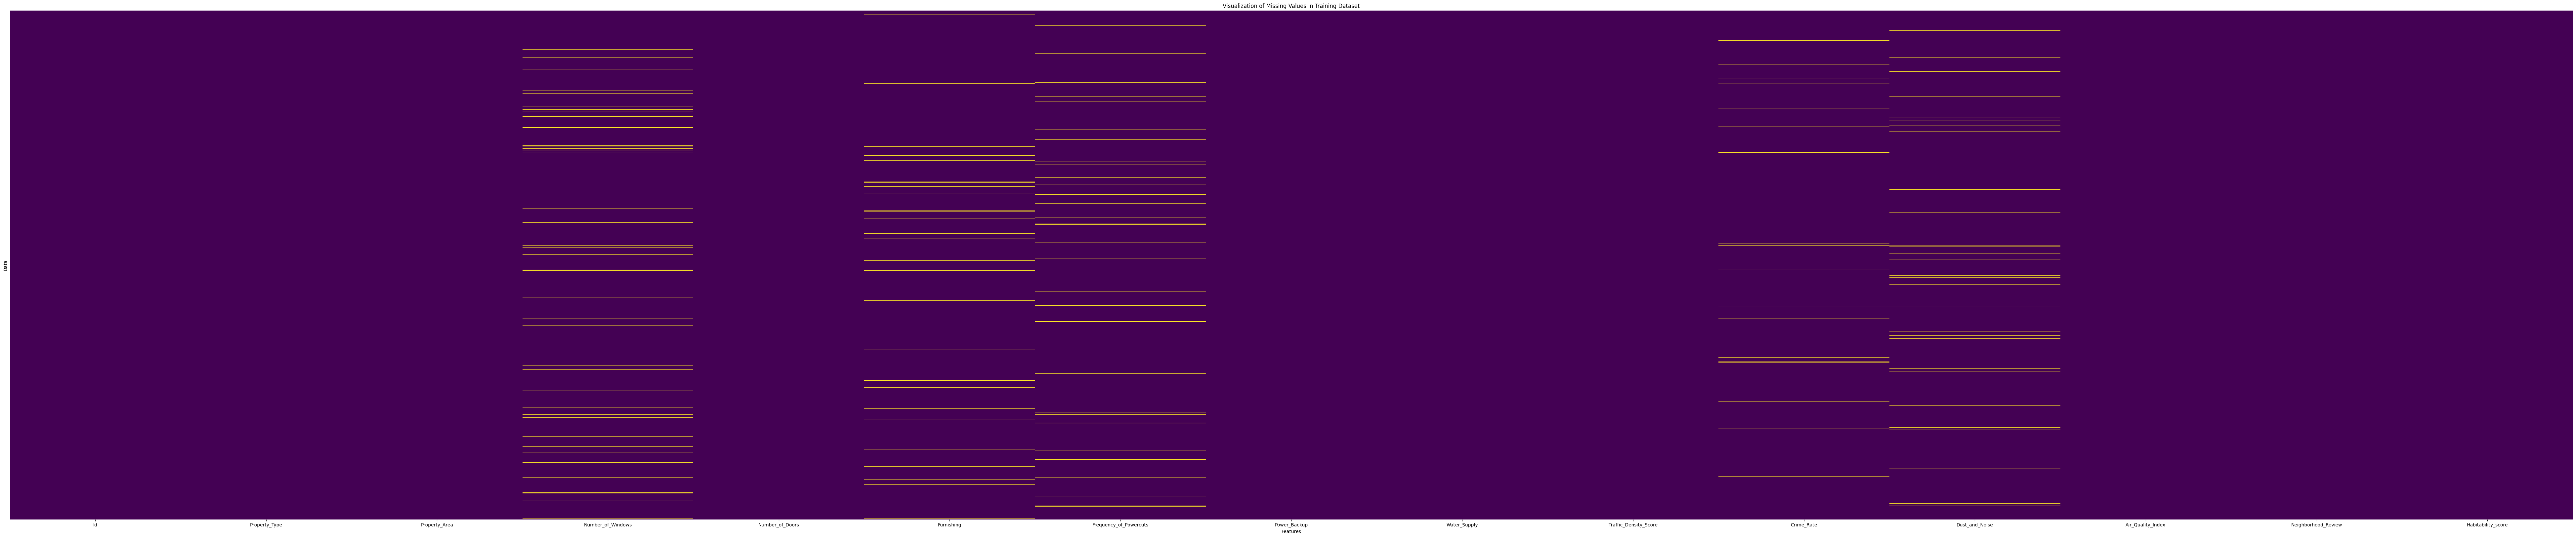

In [242]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(100,20))
sns.heatmap(train_data.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.xlabel('Features')
plt.ylabel('Data')
plt.title('Visualization of Missing Values in Training Dataset')
plt.show()

By running the below code we could get the exact numbers of missing values for each feature.

In [243]:
columns_with_missing_values = train_data.columns[train_data.isnull().any()]

for column in columns_with_missing_values:
    missing_count = train_data[column].isnull().sum()
    print(f"Column '{column}' has {missing_count} missing values.")

Column 'Number_of_Windows' has 1333 missing values.
Column 'Furnishing' has 828 missing values.
Column 'Frequency_of_Powercuts' has 1109 missing values.
Column 'Crime_Rate' has 629 missing values.
Column 'Dust_and_Noise' has 999 missing values.


When it comes to handling missing values there are different techniques we could apply. We could remove these rows altogether or use a imputation technique to handle the missing values. I tried both these techniques and the imputation technique provided the better performance. <br><br>
But I tried another technique which is Using a Model to Predict the Missing Values. This led to a further improvement in the performance. Given below is the process behind that.

In [244]:
good_features = train_data.dropna(axis=1).columns.tolist()
missing_features = [col for col in train_data.columns if col not in good_features]

print('Features with missing values :', missing_features)
print('Features without missing values :', good_features)

Features with missing values : ['Number_of_Windows', 'Furnishing', 'Frequency_of_Powercuts', 'Crime_Rate', 'Dust_and_Noise']
Features without missing values : ['Id', 'Property_Type', 'Property_Area', 'Number_of_Doors', 'Power_Backup', 'Water_Supply', 'Traffic_Density_Score', 'Air_Quality_Index', 'Neighborhood_Review', 'Habitability_score']


What I have done here is created a temporary dataset with all the complete features and one feature with missing values.

In [245]:
good_features.extend([missing_features[0]])

temp_data = train_data[good_features]
temp_data.head()

,Id,Property_Type,Property_Area,Number_of_Doors,Power_Backup,Water_Supply,Traffic_Density_Score,Air_Quality_Index,Neighborhood_Review,Habitability_score,Number_of_Windows
0,0x21e3,Apartment,106,1,No,Once in a day - Morning,5.89,90.0,3.86,71.98,NaN
1,0x68d4,Apartment,733,2,No,Once in a day - Evening,4.37,96.0,3.55,71.20,2.0
2,0x7d81,Apartment,737,2,No,Once in a day - Morning,7.45,121.0,3.81,71.39,4.0
3,0x7a57,Apartment,900,2,Yes,Once in a day - Morning,6.16,100.0,1.34,31.46,3.0
4,0x9409,Bungalow,2238,6,No,All time,5.46,116.0,4.77,93.70,14.0


Next we will pre-process this newly created dataset. We will remove the column 'Id' as this is not useful for the models we are training. We are using the Ordinal Encoder for the encoding process here. Generally when applying the ordinal encoder we have to create a ordered list for ordinal features in a regression problem. But for this process we will be using a classifier which will be explained next. Therefore we do not require an ordered list for the ordinal features. 

In [246]:
from sklearn.preprocessing import OrdinalEncoder

temp_data = temp_data.drop(columns=['Id'])
categorical_features = ['Property_Type', 'Power_Backup', 'Water_Supply'] 

ordinal_encoder = OrdinalEncoder()
temp_data[categorical_features] = ordinal_encoder.fit_transform(temp_data[categorical_features])

temp_data.head()

,Property_Type,Property_Area,Number_of_Doors,Power_Backup,Water_Supply,Traffic_Density_Score,Air_Quality_Index,Neighborhood_Review,Habitability_score,Number_of_Windows
0,1.0,106,1,1.0,3.0,5.89,90.0,3.86,71.98,NaN
1,1.0,733,2,1.0,2.0,4.37,96.0,3.55,71.20,2.0
2,1.0,737,2,1.0,3.0,7.45,121.0,3.81,71.39,4.0
3,1.0,900,2,2.0,3.0,6.16,100.0,1.34,31.46,3.0
4,2.0,2238,6,1.0,0.0,5.46,116.0,4.77,93.70,14.0


Now we will seperate the 'temp_data' dataset to two. One will contain the rows with missing data and the other will have a complete dataset. We will use the later to train the model and predict the missing values in former dataset.

In [247]:
missing_set = temp_data[temp_data.isnull().any(axis=1)]
print(missing_set.shape)

temp_data.dropna(axis=0, inplace=True)
print(temp_data.shape)

(1333, 10)
(30266, 10)


When predicting the missing values I tried a variety of models including both Regressors and Classifiers. I decided to go ahead with Classifiers because when closely analysing the features with missing values we could see that all of them have a small number of unique values. Out of the different Classifiers I tried the best performance was given from Random Forest Classifier.

In [248]:
from sklearn.ensemble import RandomForestClassifier

X_train = temp_data.drop(columns=['Number_of_Windows'])
y_train = temp_data['Number_of_Windows']

model = RandomForestClassifier()
model.fit(X_train, y_train)

X_test = missing_set.drop(columns=['Number_of_Windows'])
predicted_values = model.predict(X_test)

print(predicted_values)

[4. 2. 3. ... 2. 6. 7.]


We will create a new dataset which will merge the 'temp_data' and 'missing_set' datasets as 'combined_data'.

In [249]:
missing_set['Number_of_Windows'] = predicted_values
combined_data = pd.concat([temp_data, missing_set])
combined_data.sort_index(inplace=True)

print(combined_data)

       Property_Type  Property_Area  Number_of_Doors  Power_Backup  \
0                1.0            106                1           1.0   
1                1.0            733                2           1.0   
2                1.0            737                2           1.0   
3                1.0            900                2           2.0   
4                2.0           2238                6           1.0   
...              ...            ...              ...           ...   
31594            1.0            851                1           1.0   
31595            3.0            315                1           2.0   
31596            4.0            480                3           1.0   
31597            1.0            642                2           1.0   
31598            5.0           1738                4           1.0   

       Water_Supply  Traffic_Density_Score  Air_Quality_Index  \
0               3.0                   5.89               90.0   
1               2.0          

C:\Users\ROG\AppData\Local\Temp\ipykernel_27108\1649329363.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_set['Number_of_Windows'] = predicted_values


By running the below code you can see all the missing values have been handled for 'Number_of_Windows'.

In [250]:
print(combined_data.isnull().sum())

Property_Type            0
Property_Area            0
Number_of_Doors          0
Power_Backup             0
Water_Supply             0
Traffic_Density_Score    0
Air_Quality_Index        0
Neighborhood_Review      0
Habitability_score       0
Number_of_Windows        0
dtype: int64


We have successfully filled missing values for one column. We will repeat the same process for the other features with missing values now.

In [251]:
temp_data = combined_data
temp_data['Furnishing'] = train_data['Furnishing']

categorical_features = ['Furnishing'] 

ordinal_encoder = OrdinalEncoder()
temp_data[categorical_features] = ordinal_encoder.fit_transform(temp_data[categorical_features])

missing_set = temp_data[temp_data.isnull().any(axis=1)]
temp_data.dropna(axis=0, inplace=True)

X_train = temp_data.drop(columns=['Furnishing'])
y_train = temp_data['Furnishing']

model = RandomForestClassifier()
model.fit(X_train, y_train)
X_test = missing_set.drop(columns=['Furnishing'])
predicted_values = model.predict(X_test)

missing_set['Furnishing'] = predicted_values
combined_data = pd.concat([temp_data, missing_set])
combined_data.sort_index(inplace=True)

print(combined_data)

       Property_Type  Property_Area  Number_of_Doors  Power_Backup  \
0                1.0            106                1           1.0   
1                1.0            733                2           1.0   
2                1.0            737                2           1.0   
3                1.0            900                2           2.0   
4                2.0           2238                6           1.0   
...              ...            ...              ...           ...   
31594            1.0            851                1           1.0   
31595            3.0            315                1           2.0   
31596            4.0            480                3           1.0   
31597            1.0            642                2           1.0   
31598            5.0           1738                4           1.0   

       Water_Supply  Traffic_Density_Score  Air_Quality_Index  \
0               3.0                   5.89               90.0   
1               2.0          

C:\Users\ROG\AppData\Local\Temp\ipykernel_27108\2926209667.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_set['Furnishing'] = predicted_values


In [252]:
temp_data = combined_data
temp_data['Frequency_of_Powercuts'] = train_data['Frequency_of_Powercuts']

missing_set = temp_data[temp_data.isnull().any(axis=1)]
temp_data.dropna(axis=0, inplace=True)

X_train = temp_data.drop(columns=['Frequency_of_Powercuts'])
y_train = temp_data['Frequency_of_Powercuts']

model = RandomForestClassifier()
model.fit(X_train, y_train)
X_test = missing_set.drop(columns=['Frequency_of_Powercuts'])
predicted_values = model.predict(X_test)

missing_set['Frequency_of_Powercuts'] = predicted_values
combined_data = pd.concat([temp_data, missing_set])
combined_data.sort_index(inplace=True)

print(combined_data)

       Property_Type  Property_Area  Number_of_Doors  Power_Backup  \
0                1.0            106                1           1.0   
1                1.0            733                2           1.0   
2                1.0            737                2           1.0   
3                1.0            900                2           2.0   
4                2.0           2238                6           1.0   
...              ...            ...              ...           ...   
31594            1.0            851                1           1.0   
31595            3.0            315                1           2.0   
31596            4.0            480                3           1.0   
31597            1.0            642                2           1.0   
31598            5.0           1738                4           1.0   

       Water_Supply  Traffic_Density_Score  Air_Quality_Index  \
0               3.0                   5.89               90.0   
1               2.0          

C:\Users\ROG\AppData\Local\Temp\ipykernel_27108\830047290.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_set['Frequency_of_Powercuts'] = predicted_values


In [253]:
temp_data = combined_data
temp_data['Crime_Rate'] = train_data['Crime_Rate']

categorical_features = ['Crime_Rate'] 

ordinal_encoder = OrdinalEncoder()
temp_data[categorical_features] = ordinal_encoder.fit_transform(temp_data[categorical_features])

missing_set = temp_data[temp_data.isnull().any(axis=1)]
temp_data.dropna(axis=0, inplace=True)

X_train = temp_data.drop(columns=['Crime_Rate'])
y_train = temp_data['Crime_Rate']

model = RandomForestClassifier()
model.fit(X_train, y_train)
X_test = missing_set.drop(columns=['Crime_Rate'])
predicted_values = model.predict(X_test)

missing_set['Crime_Rate'] = predicted_values
combined_data = pd.concat([temp_data, missing_set])
combined_data.sort_index(inplace=True)

print(combined_data)

       Property_Type  Property_Area  Number_of_Doors  Power_Backup  \
0                1.0            106                1           1.0   
1                1.0            733                2           1.0   
2                1.0            737                2           1.0   
3                1.0            900                2           2.0   
4                2.0           2238                6           1.0   
...              ...            ...              ...           ...   
31594            1.0            851                1           1.0   
31595            3.0            315                1           2.0   
31596            4.0            480                3           1.0   
31597            1.0            642                2           1.0   
31598            5.0           1738                4           1.0   

       Water_Supply  Traffic_Density_Score  Air_Quality_Index  \
0               3.0                   5.89               90.0   
1               2.0          

C:\Users\ROG\AppData\Local\Temp\ipykernel_27108\28575310.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_set['Crime_Rate'] = predicted_values


In [254]:
temp_data = combined_data
temp_data['Dust_and_Noise'] = train_data['Dust_and_Noise']

categorical_features = ['Dust_and_Noise'] 

ordinal_encoder = OrdinalEncoder()
temp_data[categorical_features] = ordinal_encoder.fit_transform(temp_data[categorical_features])

missing_set = temp_data[temp_data.isnull().any(axis=1)]
temp_data.dropna(axis=0, inplace=True)

X_train = temp_data.drop(columns=['Dust_and_Noise'])
y_train = temp_data['Dust_and_Noise']

model = RandomForestClassifier()
model.fit(X_train, y_train)
X_test = missing_set.drop(columns=['Dust_and_Noise'])
predicted_values = model.predict(X_test)

missing_set['Dust_and_Noise'] = predicted_values
combined_data = pd.concat([temp_data, missing_set])
combined_data.sort_index(inplace=True)

print(combined_data)

       Property_Type  Property_Area  Number_of_Doors  Power_Backup  \
0                1.0            106                1           1.0   
1                1.0            733                2           1.0   
2                1.0            737                2           1.0   
3                1.0            900                2           2.0   
4                2.0           2238                6           1.0   
...              ...            ...              ...           ...   
31594            1.0            851                1           1.0   
31595            3.0            315                1           2.0   
31596            4.0            480                3           1.0   
31597            1.0            642                2           1.0   
31598            5.0           1738                4           1.0   

       Water_Supply  Traffic_Density_Score  Air_Quality_Index  \
0               3.0                   5.89               90.0   
1               2.0          

C:\Users\ROG\AppData\Local\Temp\ipykernel_27108\3170654232.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_set['Dust_and_Noise'] = predicted_values


Now all the missing values have been handled. Next we will go on to train the model. We skipped feature selsction because we have a limited number of features to work with here anyway. You could see the correlation matrix for the new dataset below and it doesn't show any significant correlation between features.

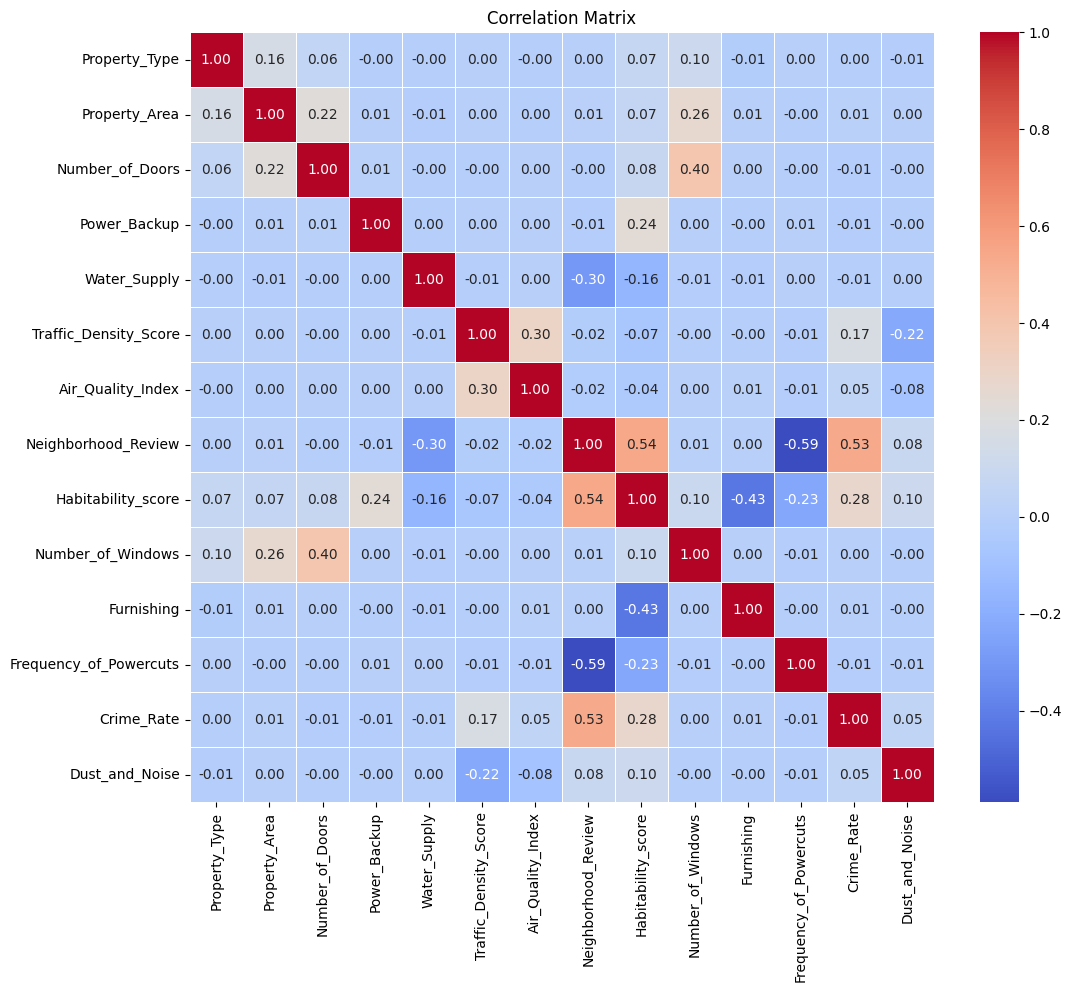

In [255]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = combined_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Model Training

In here we will be trying out multiple models and other methods to improve the performance.

First we will try Linear Regression to set a benchmark.

In [303]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler

X = combined_data.drop(columns=['Habitability_score'])
y = combined_data['Habitability_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
scaled_train = pd.DataFrame(train_scaled, columns=X_train.columns)
test_scaled = scaler.fit_transform(X_test)
scaled_test = pd.DataFrame(test_scaled, columns=X_test.columns)

xgb_regressor = LinearRegression()
xgb_regressor.fit(scaled_train, y_train)
y_pred = xgb_regressor.predict(scaled_test)

mse = root_mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error:", mse)

Root Mean Squared Error: 9.177990564597792


Next we will try XGB Regression.

In [304]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

X = combined_data.drop(columns=['Habitability_score'])
y = combined_data['Habitability_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train, y_train)
y_pred = xgb_regressor.predict(X_test)

mse = root_mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error:", mse)

Root Mean Squared Error: 5.928849629621545


Finally Random Forest Regressor which led to the best performance.

In [305]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

X = combined_data.drop(columns=['Habitability_score'])
y = combined_data['Habitability_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

mse = root_mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error (Random Forest):", mse)

Root Mean Squared Error (Random Forest): 5.629737318796106


Given below are some more evaluation metrics for the model.

In [307]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score

mae_stacked = mean_absolute_error(y_test, y_pred)
rmse_stacked = mean_squared_error(y_test, y_pred)
r2_stacked = r2_score(y_test, y_pred)
mape_stacked = mean_absolute_percentage_error(y_test, y_pred)
explained_variance_stacked = explained_variance_score(y_test, y_pred)

print("Mean Absolute Error (Random Forest):", mae_stacked)
print("Mean Squared Error (Random Forest):", rmse_stacked)
print("R-squared (Random Forest):", r2_stacked)
print("Mean Absolute Percentage Error (Random Forest):", mape_stacked)
print("Explained Variance Score (Random Forest):", explained_variance_stacked)

Mean Absolute Error (Random Forest): 4.376199462025316
Mean Squared Error (Random Forest): 31.69394227864557
R-squared (Random Forest): 0.8333234459441111
Mean Absolute Percentage Error (Random Forest): 0.06533553346644895
Explained Variance Score (Random Forest): 0.8333309439951225


The code given below can be used to check whether the model is overfitting or underfitting. If there is a large gap between the two curves then it implies that the model is overfitting. If the two curves are close to each other but the score is low then it implies that the model is underfitting.<br><br>
In this case eventhough the score is high there is a large gap between the two curves. That means the model is overfitting.

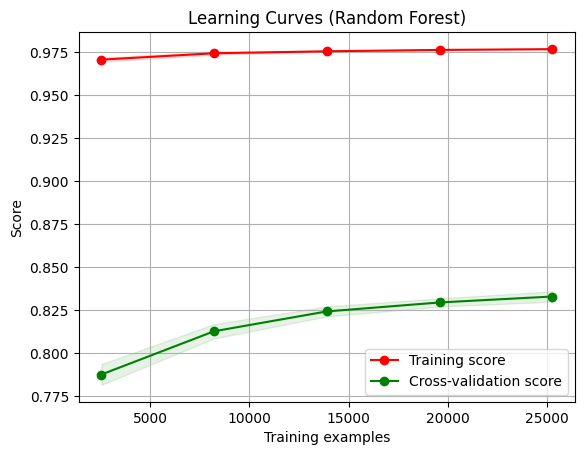

In [306]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import numpy as np

X = combined_data.drop(columns=['Habitability_score'])
y = combined_data['Habitability_score']

model = rf_regressor

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

plot_learning_curve(model, "Learning Curves (Random Forest)", X, y, cv=cv, n_jobs=-1)

plt.show()

Given below are all the models I tried out for this dataset.
1. RandomForestRegressor
2. XGBRegressor
3. ExtraTreesRegressor
4. LinearRegression
5. Ridge
6. Lasso
7. SVR
8. KNeighborsRegressor
9. DecisionTreeRegressor
10. GradientBoostingRegressor
11. AdaBoostRegressor
12. LGBMRegressor

Since there were multiple models which were giving good performance I decided to build a blended model using the best models. I used a algorithm which tried different combinations of models for the stacked model out of the above models and gave the best combination. Given below is the best combination the algorithm provided.
1. RandomForestRegressor
2. XGBRegressor
3. ExtraTreesRegressor

Given below is the code for the blended model created using the best combination. Lets look at it step by step.<br><br> 
***STEP 01 -*** Split the dataset to 60:20:20 splits for training, validating and testing sets.<br>
***STEP 02 -*** Next we train the base models using the training datsets.<br>
***STEP 03 -*** Predict target variable for the validation dataset using the trained base models.<br>
***STEP 04 -*** Create a new dataset 'stacked_X_valid' containing the predicted variables of the 3 base models.<br>
***STEP 05 -*** Train the meta model(Linear Regressor in here) using 'stacked_X_valid' and 'y_valid'.<br>
***STEP 06 -*** Carry out step 03 for the testing dataset.<br>
***STEP 07 -*** Create a new dataset 'stacked_X_test' containing the predicted variables of the 3 base models.<br>
***STEP 08 -*** Finally predict the target variable using the meta model for the 'stacked_X_test' and check the RMSE with respect to 'y_test'.

In [343]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np

X = combined_data.drop(columns=['Habitability_score']) 
y = combined_data['Habitability_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

rf_model = RandomForestRegressor()
xgb_model = XGBRegressor()
et_model = ExtraTreesRegressor()

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
et_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_valid)
xgb_preds = xgb_model.predict(X_valid)
et_preds = et_model.predict(X_valid)

stacked_X_valid = np.column_stack((rf_preds, xgb_preds, et_preds))

meta_learner = LinearRegression()
meta_learner.fit(stacked_X_valid, y_valid)

rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
et_preds = et_model.predict(X_test)

stacked_X_test = np.column_stack((rf_preds, xgb_preds, et_preds))

stacked_preds = meta_learner.predict(stacked_X_test)

mse_stacked = root_mean_squared_error(y_test, stacked_preds)
print("Root Mean Squared Error (Stacked Model):", mse_stacked)

Root Mean Squared Error (Stacked Model): 5.244750630112251


Given below are some more evaluation metrics for the above model.

In [344]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score

mae_stacked = mean_absolute_error(y_test, stacked_preds)
rmse_stacked = mean_squared_error(y_test, stacked_preds)
r2_stacked = r2_score(y_test, stacked_preds)
mape_stacked = mean_absolute_percentage_error(y_test, stacked_preds)
explained_variance_stacked = explained_variance_score(y_test, stacked_preds)

print("Mean Absolute Error (Stacked Model):", mae_stacked)
print("Mean Squared Error (Stacked Model):", rmse_stacked)
print("R-squared (Stacked Model):", r2_stacked)
print("Mean Absolute Percentage Error (Stacked Model):", mape_stacked)
print("Explained Variance Score (Stacked Model):", explained_variance_stacked)

Mean Absolute Error (Stacked Model): 3.6115646241440813
Mean Squared Error (Stacked Model): 27.50740917206285
R-squared (Stacked Model): 0.858834764887683
Mean Absolute Percentage Error (Stacked Model): 0.053978607203346574
Explained Variance Score (Stacked Model): 0.8588356932169027


Next we have to do hyper parameter tuning for the base models. As you can see below we have used Randomized Search for the hyper parameter tuning with 3 tests for each combination and 300 combinations for each model. This code will take a long time to run therefore you could skip this code.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.stats import randint, uniform

X = combined_data.drop(columns=['Habitability_score'])
y = combined_data['Habitability_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_param_grid = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

xgb_param_grid = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(1, 20),
    'learning_rate': uniform(0.01, 0.3)
}

et_param_grid = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

kf = KFold(n_splits=3, shuffle=True, random_state=42)
rf_grid = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=rf_param_grid, n_iter=300, scoring='neg_mean_squared_error', cv=kf, verbose=4, random_state=42)
xgb_grid = RandomizedSearchCV(estimator=XGBRegressor(), param_distributions=xgb_param_grid, n_iter=300, scoring='neg_mean_squared_error', cv=kf, verbose=4, random_state=42)
et_grid = RandomizedSearchCV(estimator=ExtraTreesRegressor(), param_distributions=et_param_grid, n_iter=300, scoring='neg_mean_squared_error', cv=kf, verbose=4, random_state=42)

rf_grid.fit(X_train, y_train)
xgb_grid.fit(X_train, y_train)
et_grid.fit(X_train, y_train)

best_rf_model = rf_grid.best_estimator_
best_xgb_model = xgb_grid.best_estimator_
best_et_model = et_grid.best_estimator_

rf_preds = best_rf_model.predict(X_test)
xgb_preds = best_xgb_model.predict(X_test)
et_preds = best_et_model.predict(X_test)

stacked_X_train = np.column_stack((rf_preds, xgb_preds, et_preds))

meta_param_grid = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

meta_grid = GridSearchCV(estimator=LinearRegression(), param_grid=meta_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose= 2)
meta_grid.fit(stacked_X_train, y_test)

best_meta_learner = meta_grid.best_estimator_

stacked_preds = best_meta_learner.predict(stacked_X_train)

mse_stacked_tuned = root_mean_squared_error(y_test, stacked_preds)
print("Root Mean Squared Error (Tuned Stacked Model):", mse_stacked_tuned)

Best hyperparameters for Random Forest:
{'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': , 'n_estimators': 225}

Best hyperparameters for XGBoost:
{'learning_rate': 0.02604558902421067, 'max_depth': 9, 'n_estimators': 246}

Best hyperparameters for Extra Trees:
{'max_depth': 17, 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 260}

Given below is the code with the tuned set of hyper parameters for the base models.

In [349]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression

X = combined_data.drop(columns=['Habitability_score']) 
y = combined_data['Habitability_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

rf_model = RandomForestRegressor(max_depth=13, min_samples_leaf=1, min_samples_split=3, n_estimators=225)
xgb_model = XGBRegressor(max_depth=9, learning_rate=0.02604558902421067, n_estimators=246)
et_model = ExtraTreesRegressor(max_depth=17, min_samples_leaf=1, min_samples_split=9, n_estimators=260)

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
et_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_valid)
xgb_preds = xgb_model.predict(X_valid)
et_preds = et_model.predict(X_valid)

stacked_X_valid = np.column_stack((rf_preds, xgb_preds, et_preds))

meta_learner = LinearRegression()
meta_learner.fit(stacked_X_valid, y_valid)

rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
et_preds = et_model.predict(X_test)

stacked_X_test = np.column_stack((rf_preds, xgb_preds, et_preds))

stacked_preds = meta_learner.predict(stacked_X_test)

mse_stacked = root_mean_squared_error(y_test, stacked_preds)
print("Root Mean Squared Error (Stacked Model):", mse_stacked)


Root Mean Squared Error (Stacked Model): 5.363195308240001


Given below are some more evaluation metrics for the above model.

In [309]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score

mae_stacked = mean_absolute_error(y_test, stacked_preds)
rmse_stacked = mean_squared_error(y_test, stacked_preds)
r2_stacked = r2_score(y_test, stacked_preds)
mape_stacked = mean_absolute_percentage_error(y_test, stacked_preds)
explained_variance_stacked = explained_variance_score(y_test, stacked_preds)

print("Mean Absolute Error (Stacked Model):", mae_stacked)
print("Mean Squared Error (Stacked Model):", rmse_stacked)
print("R-squared (Stacked Model):", r2_stacked)
print("Mean Absolute Percentage Error (Stacked Model):", mape_stacked)
print("Explained Variance Score (Stacked Model):", explained_variance_stacked)

Mean Absolute Error (Stacked Model): 4.133436319685719
Mean Squared Error (Stacked Model): 28.803406234333096
R-squared (Stacked Model): 0.8521838393550065
Mean Absolute Percentage Error (Stacked Model): 0.06140286110315043
Explained Variance Score (Stacked Model): 0.8521844792174977


Next we will try a few variations for the meta model as well. I tried boosting models for the meta model to improve the performance.

In [310]:
xgb_meta_learner = XGBRegressor()
xgb_meta_learner.fit(stacked_X_valid, y_valid)

stacked_preds = xgb_meta_learner.predict(stacked_X_test)

mse_stacked = root_mean_squared_error(y_test, stacked_preds)
print("Root Mean Squared Error (Stacked Model):", mse_stacked)

Root Mean Squared Error (Stacked Model): 5.540434088369441


In [311]:
from sklearn.ensemble import AdaBoostRegressor

scaler = StandardScaler()

stacked_X_valid_scaled = scaler.fit_transform(stacked_X_valid)
stacked_X_test_scaled = scaler.fit_transform(stacked_X_test)

ada_meta_learner = AdaBoostRegressor()
ada_meta_learner.fit(stacked_X_valid_scaled, y_valid)

stacked_preds = ada_meta_learner.predict(stacked_X_test_scaled)

mse_stacked = root_mean_squared_error(y_test, stacked_preds)
print("Root Mean Squared Error (Stacked Model):", mse_stacked)

Root Mean Squared Error (Stacked Model): 5.486109719893771


In [312]:
from sklearn.ensemble import GradientBoostingRegressor

gbm_meta_learner = GradientBoostingRegressor()
gbm_meta_learner.fit(stacked_X_valid, y_valid)

stacked_preds = gbm_meta_learner.predict(stacked_X_test)

mse_stacked = root_mean_squared_error(y_test, stacked_preds)
print("Root Mean Squared Error (Stacked Model):", mse_stacked)

Root Mean Squared Error (Stacked Model): 5.356564366375826


In [314]:
from lightgbm import LGBMRegressor

lgbm_meta_learner = LGBMRegressor()
lgbm_meta_learner.fit(stacked_X_valid, y_valid)

stacked_preds = lgbm_meta_learner.predict(stacked_X_test)

mse_stacked = root_mean_squared_error(y_test, stacked_preds)
print("Root Mean Squared Error (Stacked Model):", mse_stacked)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 15799, number of used features: 3
[LightGBM] [Info] Start training from score 73.350541
Root Mean Squared Error (Stacked Model): 5.4166064794824065


From the above tests you can see that the best performing model is the Gradient Boosting Regressor. Now lets do hyper parametr tuning to this model. We will be using Randomized Search with 3 test for each combination and 1000 combinations altogether. This will take a long time to run therefore you could ignore this code.

In [48]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(1, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Create the Gradient Boosting meta-learner
gbm_meta_learner = GradientBoostingRegressor()

# Perform RandomizedSearchCV for hyperparameter tuning
gbm_random_search = RandomizedSearchCV(estimator=gbm_meta_learner, param_distributions=param_dist, n_iter=1000, cv=3, random_state=42, verbose=3, n_jobs=-1)
gbm_random_search.fit(stacked_X_valid, y_valid)

# Get the best model from RandomizedSearchCV
best_gbm_meta_learner = gbm_random_search.best_estimator_

# Generate predictions from the stacked model
stacked_preds = best_gbm_meta_learner.predict(stacked_X_test)

# Calculate Root Mean Squared Error
mse_stacked = root_mean_squared_error(y_test, stacked_preds)
print("Root Mean Squared Error (Stacked Model):", mse_stacked)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
Root Mean Squared Error (Stacked Model): 5.355021790032898


Best hyperparameters for GBM:
{'learning_rate': 0.079535077086805, 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 236} <br>
Below code runs with the tuned set of hyper parameters.

In [315]:
from sklearn.ensemble import GradientBoostingRegressor

gbm_meta_learner = GradientBoostingRegressor(learning_rate=0.079535077086805, max_depth=1, min_samples_leaf=1, min_samples_split=6, n_estimators=236)
gbm_meta_learner.fit(stacked_X_valid, y_valid)

stacked_preds = gbm_meta_learner.predict(stacked_X_test)

mse_stacked = root_mean_squared_error(y_test, stacked_preds)
print("Root Mean Squared Error (Stacked Model):", mse_stacked)

Root Mean Squared Error (Stacked Model): 5.352064655434482


Given below are some more evaluation metrics for the above model.

In [317]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score

mae_stacked = mean_absolute_error(y_test, stacked_preds)
rmse_stacked = mean_squared_error(y_test, stacked_preds)
r2_stacked = r2_score(y_test, stacked_preds)
mape_stacked = mean_absolute_percentage_error(y_test, stacked_preds)
explained_variance_stacked = explained_variance_score(y_test, stacked_preds)

print("Mean Absolute Error (Stacked Model):", mae_stacked)
print("Mean Squared Error (Stacked Model):", rmse_stacked)
print("R-squared (Stacked Model):", r2_stacked)
print("Mean Absolute Percentage Error (Stacked Model):", mape_stacked)
print("Explained Variance Score (Stacked Model):", explained_variance_stacked)

Mean Absolute Error (Stacked Model): 4.127729223381331
Mean Squared Error (Stacked Model): 28.644596075951018
R-squared (Stacked Model): 0.8529988369873172
Mean Absolute Percentage Error (Stacked Model): 0.061156231834769315
Explained Variance Score (Stacked Model): 0.8529990399269911


We will check whether this model is overfitting or a=underfitting as well. As you can see both curves are close to each other and the scores are also good.

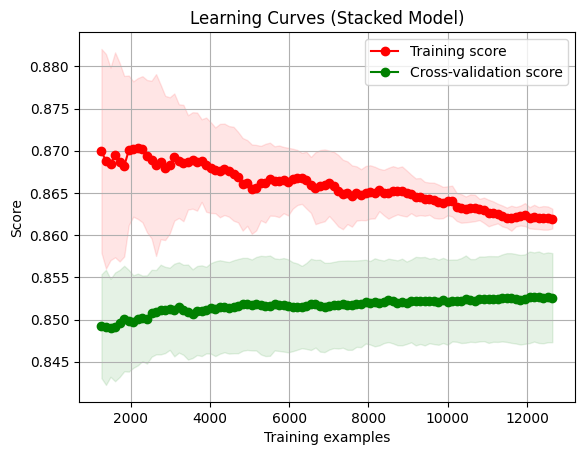

In [316]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit

X = stacked_X_test 
y = y_test 

model = gbm_meta_learner

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 100)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

plot_learning_curve(model, "Learning Curves (Stacked Model)", X, y, cv=cv, n_jobs=-1)

plt.show()

I also tried Regularization through Lasso and Ridge methods because the scores I get when i submitted to the Kaggle competition was higher than when I'm testing the models. In here Lasso performed better than Ridge regression.

In [350]:
from sklearn.linear_model import Lasso, Ridge

scaler = StandardScaler()

stacked_X_valid_scaled = scaler.fit_transform(stacked_X_valid)

meta_learner = Lasso(alpha=0.1)  # L1 (Lasso) regularization
# meta_learner = Ridge(alpha=0.9)  # L2 (Ridge) regularization

meta_learner.fit(stacked_X_valid_scaled, y_valid)

stacked_X_test_scaled = scaler.fit_transform(stacked_X_test)
stacked_preds = meta_learner.predict(stacked_X_test_scaled)

mse_stacked = root_mean_squared_error(y_test, stacked_preds)
print("Root Mean Squared Error (Regularized Stacked Model):", mse_stacked)

Root Mean Squared Error (Regularized Stacked Model): 5.386956791860444


Given below are some more evaluation metrics for the above model.

In [351]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error, mean_squared_log_error

mae_stacked = mean_absolute_error(y_test, stacked_preds)
rmse_stacked = mean_squared_error(y_test, stacked_preds)
r2_stacked = r2_score(y_test, stacked_preds)
mape_stacked = mean_absolute_percentage_error(y_test, stacked_preds)
explained_variance_stacked = explained_variance_score(y_test, stacked_preds)
max_err_stacked = max_error(y_test, stacked_preds)
mean_squared_log_err_stacked = mean_squared_log_error(y_test, stacked_preds)

print("Mean Absolute Error (Stacked Model):", mae_stacked)
print("Mean Squared Error (Stacked Model):", rmse_stacked)
print("R-squared (Stacked Model):", r2_stacked)
print("Mean Absolute Percentage Error (Stacked Model):", mape_stacked)
print("Explained Variance Score (Stacked Model):", explained_variance_stacked)
print("Max Error (Stacked Model):", max_err_stacked)
print("Mean Squared Log Error (Stacked Model):", mean_squared_log_err_stacked)

Mean Absolute Error (Stacked Model): 4.143820939580833
Mean Squared Error (Stacked Model): 29.01930347737137
R-squared (Stacked Model): 0.8510758765918485
Mean Absolute Percentage Error (Stacked Model): 0.06144337899991974
Explained Variance Score (Stacked Model): 0.8512308082536888
Max Error (Stacked Model): 40.89042940836921
Mean Squared Log Error (Stacked Model): 0.0073521119987292665


This is the final model selected as out of the all the different models tried out this is the one which gave the best the best score in the kaggle competition.<br><br>
Given below is some analysis on the dataset. 

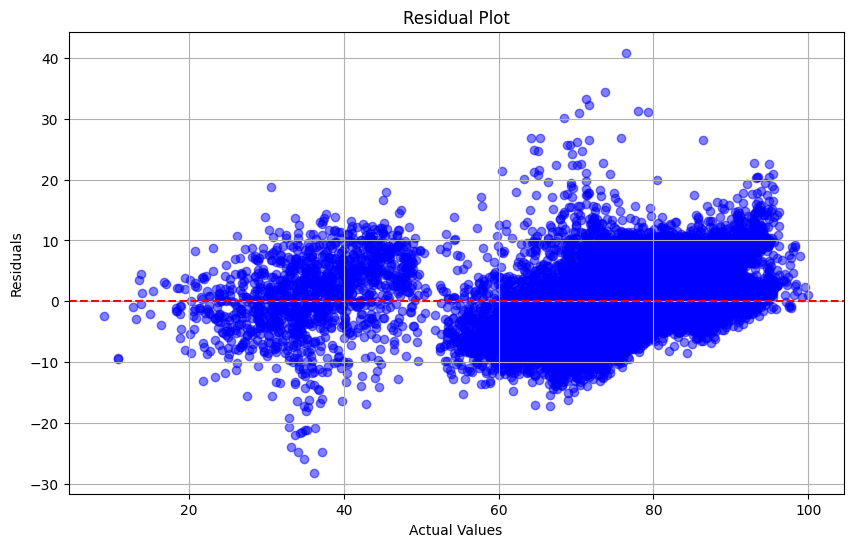

In [354]:
import matplotlib.pyplot as plt

residuals = y_test - stacked_preds

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

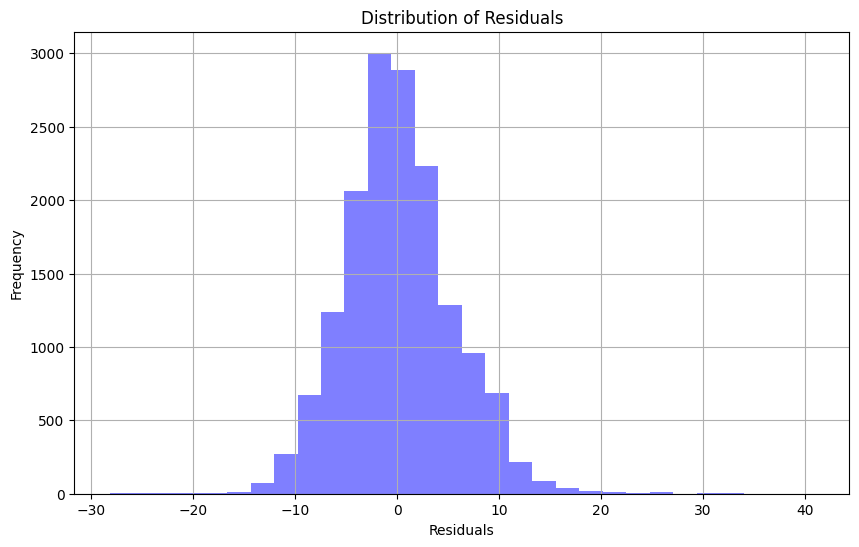

In [355]:
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='blue', alpha=0.5)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Code given below checks whether the model is overfitting or underfitting. Both curves are close to each other, that means there is no overfitting. As we have regularized the model this shouldn't come as a suprise. From the visualization we could see that this model is even better than the GBM model that we tried earlier.

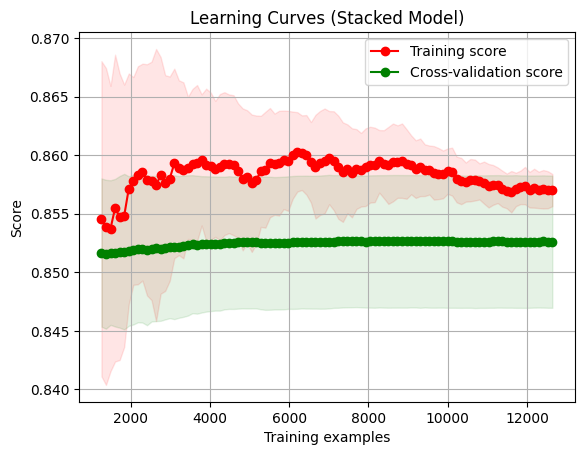

In [353]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit

X = stacked_X_test_scaled 
y = y_test 

model = meta_learner

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 100)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

plot_learning_curve(model, "Learning Curves (Stacked Model)", X, y, cv=cv, n_jobs=-1)

plt.show()

## Pre-processing Testing Dataset

We will apply the same pre-processing techniques applied to the training dataset here as well.

In [322]:
import pandas as pd

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print('The shape of training dataset : ' + str(train_data.shape))
print('The shape of testing dataset : ' + str(test_data.shape))

The shape of training dataset : (31599, 15)
The shape of testing dataset : (7900, 14)


In [323]:
good_features = test_data.dropna(axis=1).columns.tolist()
missing_features = [col for col in test_data.columns if col not in good_features]

print('Features with missing values :', missing_features)
print('Features without missing values :', good_features)

Features with missing values : ['Number_of_Windows', 'Furnishing', 'Frequency_of_Powercuts', 'Crime_Rate', 'Dust_and_Noise']
Features without missing values : ['Id', 'Property_Type', 'Property_Area', 'Number_of_Doors', 'Power_Backup', 'Water_Supply', 'Traffic_Density_Score', 'Air_Quality_Index', 'Neighborhood_Review']


In [324]:
good_features.extend([missing_features[0]])
print(good_features)

['Id', 'Property_Type', 'Property_Area', 'Number_of_Doors', 'Power_Backup', 'Water_Supply', 'Traffic_Density_Score', 'Air_Quality_Index', 'Neighborhood_Review', 'Number_of_Windows']


In [325]:
temp_data = test_data[good_features]
temp_data.head()

,Id,Property_Type,Property_Area,Number_of_Doors,Power_Backup,Water_Supply,Traffic_Density_Score,Air_Quality_Index,Neighborhood_Review,Number_of_Windows
0,0x6808,Single-family home,1521,1,No,All time,7.61,156.0,4.71,5.0
1,0x6a98,Single-family home,2233,1,No,Once in a day - Morning,5.28,82.0,4.50,2.0
2,0xacc0,Apartment,986,1,No,All time,7.72,91.0,4.79,1.0
3,0x8225,Single-family home,1625,1,No,Once in a day - Evening,6.19,159.0,4.09,2.0
4,0xaee8,Single-family home,1166,2,No,Once in a day - Evening,5.84,82.0,3.56,2.0


In [326]:
from sklearn.preprocessing import OrdinalEncoder

temp_data = temp_data.drop(columns=['Id'])
categorical_features = ['Property_Type', 'Power_Backup', 'Water_Supply'] 

ordinal_encoder = OrdinalEncoder()
temp_data[categorical_features] = ordinal_encoder.fit_transform(temp_data[categorical_features])

temp_data.head()

,Property_Type,Property_Area,Number_of_Doors,Power_Backup,Water_Supply,Traffic_Density_Score,Air_Quality_Index,Neighborhood_Review,Number_of_Windows
0,5.0,1521,1,1.0,0.0,7.61,156.0,4.71,5.0
1,5.0,2233,1,1.0,3.0,5.28,82.0,4.50,2.0
2,1.0,986,1,1.0,0.0,7.72,91.0,4.79,1.0
3,5.0,1625,1,1.0,2.0,6.19,159.0,4.09,2.0
4,5.0,1166,2,1.0,2.0,5.84,82.0,3.56,2.0


In [327]:
missing_set = temp_data[temp_data.isnull().any(axis=1)]
print(missing_set.shape)

temp_data.dropna(axis=0, inplace=True)
print(temp_data.shape)

(321, 9)
(7579, 9)


In [328]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

X_train = temp_data.drop(columns=['Number_of_Windows'])
y_train = temp_data['Number_of_Windows']

model = RandomForestClassifier()
model.fit(X_train, y_train)

X_test = missing_set.drop(columns=['Number_of_Windows'])
predicted_values = model.predict(X_test)

print(predicted_values)

[ 8.  4.  3.  3.  4.  2. 14.  1.  4.  3.  3.  2.  2.  3.  3.  2.  6.  3.
  2.  5.  1.  4.  3.  4.  3.  7.  1.  2.  4.  6.  5.  5.  2.  1.  3.  4.
  2.  1.  4.  4. 13.  3.  4.  4.  6.  5.  2. 14.  4.  4.  2. 14.  3.  5.
  4.  7.  3.  5.  5.  5.  1.  2.  3.  7.  1.  5.  5.  3.  7.  3.  2.  4.
  5.  3.  2.  2.  2.  3.  4.  0.  3.  6.  4.  3.  4.  6.  4.  5.  2.  5.
  9.  3.  4.  4.  4. 13.  1.  3.  3.  5.  4.  3.  3.  2.  3.  0. 11.  4.
  2.  2.  1.  9.  2.  4.  1.  3.  3.  5.  3.  8.  5.  3.  4.  2.  7.  5.
  6.  4.  5.  7. 11.  3.  2.  3.  3.  4.  4.  1.  2.  2.  4.  2.  2.  3.
  5.  4.  2.  2.  1.  3.  3.  2.  5.  2.  4.  5.  2.  4.  6.  3.  2.  3.
  1.  6.  2.  4.  4.  4.  5.  4.  7.  3.  2.  2.  1.  5.  3.  2.  3.  2.
  3.  6.  1.  5.  2.  2.  6.  7.  3.  3.  5.  3.  5.  3.  2.  1.  1.  2.
  4.  5.  5.  5.  2.  3.  2.  7.  4.  1.  3.  4.  4.  3.  2.  4.  3.  2.
  1.  3.  4.  3.  2.  4.  4.  5.  5.  7.  2.  1.  3.  3.  7.  2.  1.  3.
 15.  4.  5.  5.  4.  3.  2.  1.  3.  3.  4.  4.  1

In [329]:
missing_set['Number_of_Windows'] = predicted_values
combined_test = pd.concat([temp_data, missing_set])
combined_test.sort_index(inplace=True)

print(combined_test)

      Property_Type  Property_Area  Number_of_Doors  Power_Backup  \
0               5.0           1521                1           1.0   
1               5.0           2233                1           1.0   
2               1.0            986                1           1.0   
3               5.0           1625                1           1.0   
4               5.0           1166                2           1.0   
...             ...            ...              ...           ...   
7895            5.0           1120                2           1.0   
7896            1.0            445                3           1.0   
7897            2.0           3780                6           2.0   
7898            5.0           1266                1           1.0   
7899            5.0           1229                4           1.0   

      Water_Supply  Traffic_Density_Score  Air_Quality_Index  \
0              0.0                   7.61              156.0   
1              3.0                   5.28  

C:\Users\ROG\AppData\Local\Temp\ipykernel_27108\2114650630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_set['Number_of_Windows'] = predicted_values


In [330]:
temp_data = combined_test
temp_data['Furnishing'] = test_data['Furnishing']

categorical_features = ['Furnishing'] 

ordinal_encoder = OrdinalEncoder()
temp_data[categorical_features] = ordinal_encoder.fit_transform(temp_data[categorical_features])

missing_set = temp_data[temp_data.isnull().any(axis=1)]
temp_data.dropna(axis=0, inplace=True)

X_train = temp_data.drop(columns=['Furnishing'])
y_train = temp_data['Furnishing']

model = RandomForestClassifier()
model.fit(X_train, y_train)
X_test = missing_set.drop(columns=['Furnishing'])
predicted_values = model.predict(X_test)

missing_set['Furnishing'] = predicted_values
combined_test = pd.concat([temp_data, missing_set])
combined_test.sort_index(inplace=True)

print(combined_test)

      Property_Type  Property_Area  Number_of_Doors  Power_Backup  \
0               5.0           1521                1           1.0   
1               5.0           2233                1           1.0   
2               1.0            986                1           1.0   
3               5.0           1625                1           1.0   
4               5.0           1166                2           1.0   
...             ...            ...              ...           ...   
7895            5.0           1120                2           1.0   
7896            1.0            445                3           1.0   
7897            2.0           3780                6           2.0   
7898            5.0           1266                1           1.0   
7899            5.0           1229                4           1.0   

      Water_Supply  Traffic_Density_Score  Air_Quality_Index  \
0              0.0                   7.61              156.0   
1              3.0                   5.28  

C:\Users\ROG\AppData\Local\Temp\ipykernel_27108\4254091000.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_set['Furnishing'] = predicted_values


In [331]:
temp_data = combined_test
temp_data['Frequency_of_Powercuts'] = test_data['Frequency_of_Powercuts']

missing_set = temp_data[temp_data.isnull().any(axis=1)]
temp_data.dropna(axis=0, inplace=True)

X_train = temp_data.drop(columns=['Frequency_of_Powercuts'])
y_train = temp_data['Frequency_of_Powercuts']

model = RandomForestClassifier()
model.fit(X_train, y_train)
X_test = missing_set.drop(columns=['Frequency_of_Powercuts'])
predicted_values = model.predict(X_test)

missing_set['Frequency_of_Powercuts'] = predicted_values
combined_test = pd.concat([temp_data, missing_set])
combined_test.sort_index(inplace=True)

print(combined_test)

      Property_Type  Property_Area  Number_of_Doors  Power_Backup  \
0               5.0           1521                1           1.0   
1               5.0           2233                1           1.0   
2               1.0            986                1           1.0   
3               5.0           1625                1           1.0   
4               5.0           1166                2           1.0   
...             ...            ...              ...           ...   
7895            5.0           1120                2           1.0   
7896            1.0            445                3           1.0   
7897            2.0           3780                6           2.0   
7898            5.0           1266                1           1.0   
7899            5.0           1229                4           1.0   

      Water_Supply  Traffic_Density_Score  Air_Quality_Index  \
0              0.0                   7.61              156.0   
1              3.0                   5.28  

C:\Users\ROG\AppData\Local\Temp\ipykernel_27108\3448005464.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_set['Frequency_of_Powercuts'] = predicted_values


In [332]:
temp_data = combined_test
temp_data['Crime_Rate'] = test_data['Crime_Rate']

categorical_features = ['Crime_Rate'] 

ordinal_encoder = OrdinalEncoder()
temp_data[categorical_features] = ordinal_encoder.fit_transform(temp_data[categorical_features])

missing_set = temp_data[temp_data.isnull().any(axis=1)]
temp_data.dropna(axis=0, inplace=True)

X_train = temp_data.drop(columns=['Crime_Rate'])
y_train = temp_data['Crime_Rate']

model = RandomForestClassifier()
model.fit(X_train, y_train)
X_test = missing_set.drop(columns=['Crime_Rate'])
predicted_values = model.predict(X_test)

missing_set['Crime_Rate'] = predicted_values
combined_test = pd.concat([temp_data, missing_set])
combined_test.sort_index(inplace=True)

print(combined_test)

      Property_Type  Property_Area  Number_of_Doors  Power_Backup  \
0               5.0           1521                1           1.0   
1               5.0           2233                1           1.0   
2               1.0            986                1           1.0   
3               5.0           1625                1           1.0   
4               5.0           1166                2           1.0   
...             ...            ...              ...           ...   
7895            5.0           1120                2           1.0   
7896            1.0            445                3           1.0   
7897            2.0           3780                6           2.0   
7898            5.0           1266                1           1.0   
7899            5.0           1229                4           1.0   

      Water_Supply  Traffic_Density_Score  Air_Quality_Index  \
0              0.0                   7.61              156.0   
1              3.0                   5.28  

C:\Users\ROG\AppData\Local\Temp\ipykernel_27108\3254943873.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_set['Crime_Rate'] = predicted_values


In [333]:
temp_data = combined_test
temp_data['Dust_and_Noise'] = test_data['Dust_and_Noise']

categorical_features = ['Dust_and_Noise'] 

ordinal_encoder = OrdinalEncoder()
temp_data[categorical_features] = ordinal_encoder.fit_transform(temp_data[categorical_features])

missing_set = temp_data[temp_data.isnull().any(axis=1)]
temp_data.dropna(axis=0, inplace=True)

X_train = temp_data.drop(columns=['Dust_and_Noise'])
y_train = temp_data['Dust_and_Noise']

model = RandomForestClassifier()
model.fit(X_train, y_train)
X_test = missing_set.drop(columns=['Dust_and_Noise'])
predicted_values = model.predict(X_test)

missing_set['Dust_and_Noise'] = predicted_values
combined_test = pd.concat([temp_data, missing_set])
combined_test.sort_index(inplace=True)

print(combined_test)

      Property_Type  Property_Area  Number_of_Doors  Power_Backup  \
0               5.0           1521                1           1.0   
1               5.0           2233                1           1.0   
2               1.0            986                1           1.0   
3               5.0           1625                1           1.0   
4               5.0           1166                2           1.0   
...             ...            ...              ...           ...   
7895            5.0           1120                2           1.0   
7896            1.0            445                3           1.0   
7897            2.0           3780                6           2.0   
7898            5.0           1266                1           1.0   
7899            5.0           1229                4           1.0   

      Water_Supply  Traffic_Density_Score  Air_Quality_Index  \
0              0.0                   7.61              156.0   
1              3.0                   5.28  

C:\Users\ROG\AppData\Local\Temp\ipykernel_27108\32938473.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_set['Dust_and_Noise'] = predicted_values


In [334]:
print(combined_test.isnull().sum())

Property_Type             0
Property_Area             0
Number_of_Doors           0
Power_Backup              0
Water_Supply              0
Traffic_Density_Score     0
Air_Quality_Index         0
Neighborhood_Review       0
Number_of_Windows         0
Furnishing                0
Frequency_of_Powercuts    0
Crime_Rate                0
Dust_and_Noise            0
dtype: int64


In [335]:
combined_test.head()

,Property_Type,Property_Area,Number_of_Doors,Power_Backup,Water_Supply,Traffic_Density_Score,Air_Quality_Index,Neighborhood_Review,Number_of_Windows,Furnishing,Frequency_of_Powercuts,Crime_Rate,Dust_and_Noise
0,5.0,1521,1,1.0,0.0,7.61,156.0,4.71,5.0,2.0,0.0,3.0,2.0
1,5.0,2233,1,1.0,3.0,5.28,82.0,4.50,2.0,1.0,0.0,3.0,2.0
2,1.0,986,1,1.0,0.0,7.72,91.0,4.79,1.0,2.0,0.0,3.0,2.0
3,5.0,1625,1,1.0,2.0,6.19,159.0,4.09,2.0,1.0,0.0,3.0,2.0
4,5.0,1166,2,1.0,2.0,5.84,82.0,3.56,2.0,0.0,0.0,1.0,2.0


Finally we will predict the target variable for the test dataset using the model that we created earlier and write it to a new csv file in the format required for the competition.

In [336]:
import pandas as pd

test_data = combined_test
test1 = pd.read_csv("test.csv")

rf_preds = rf_model.predict(test_data)
xgb_preds = xgb_model.predict(test_data)
et_preds = et_model.predict(test_data)

stacked_test_data = np.column_stack((rf_preds, xgb_preds, et_preds))

scaler = StandardScaler()

stacked_test_data_scaled = scaler.fit_transform(stacked_test_data)
stacked_preds = meta_learner.predict(stacked_test_data_scaled)

test_data['Habitability_score'] = stacked_preds
predictions_df = pd.DataFrame({'Id': test1['Id'], 'Habitability_score': test_data['Habitability_score']})

predictions_df.to_csv("predictions.csv", index=False)